In [1]:
import numpy as np
import pandas as pd
from numpy.linalg import matrix_rank, inv
from pprint import pprint
import scipy.io
import cma
import warnings
import random
import scipy.special as scis
import scipy.spatial as scispa
from cma import CMAEvolutionStrategy
mat_data = scipy.io.loadmat('mat/inv_transf.mat')
X = mat_data['input'] # Load the .mat file, [Y1,Rho1,Mu1,Rhow,Muw,Utau]
Y = mat_data['output']
index_data = mat_data['index']
index_data = index_data.ravel()
y_plus_c = (X[:, 0] * X[:, 1] * X[:, 5]) / X[:, 2]
y_plus_c = y_plus_c.reshape(-1,1)
data = scipy.io.loadmat('mat/incom_ref.mat')
y_plus = data['y_plus']
U_utau = data['U_utau']

In [2]:
D_in = np.matrix('1  -3  -1 -3 -1 1; 0 0 -1 0 -1 -1; 0 1 1 1 1 0')

print("Rank of D_in:", matrix_rank(D_in))
print("D_in matrix:\n", D_in)
num_rows   = np.shape(D_in)[0]
num_cols   = np.shape(D_in)[1]
# Function to calculate basis matrices
def calc_basis(D_in, col_range):
    num_rows   = np.shape(D_in)[0]
    num_cols   = np.shape(D_in)[1]
    Din1, Din2 = D_in[:, :num_rows], D_in[:, num_rows:]
    basis_matrices = []
    for i in range(col_range):
        x2 = np.zeros((col_range, 1))
        x2[i, 0] = -1
        x1 = -inv(Din1) * Din2 * x2
        basis_matrices.append(np.vstack((x1, x2)))
    return np.asmatrix(np.array(basis_matrices))
# Generate basis matrices
num_basis      = D_in.shape[1] -matrix_rank(D_in)
basis_matrices = calc_basis(D_in, num_basis)
basis_matrices[-1, :] = -basis_matrices[-1, :]
print("Basis vectors:")
pprint(basis_matrices)

Rank of D_in: 3
D_in matrix:
 [[ 1 -3 -1 -3 -1  1]
 [ 0  0 -1  0 -1 -1]
 [ 0  1  1  1  1  0]]
Basis vectors:
matrix([[ 0.,  1.,  0., -1.,  0.,  0.],
        [ 0.,  0.,  1.,  0., -1.,  0.],
        [ 1.,  1., -1., -0., -0.,  1.]])


In [3]:
def calc_pi(a, basis_matrices,X):
    coef_pi = np.dot(a, basis_matrices)  # Computes the weighted sum of basis matrices
    pi_mat = np.ones((X.shape[0], 1))
    for i in range(coef_pi.shape[1]):
        tmp = X[:, i] ** coef_pi[:, i]
        pi_mat = np.multiply(pi_mat, tmp.reshape(-1, 1))
    return pi_mat
def calc_pi_omega(coef_pi, X):
    pi_mat = np.ones((X.shape[0], 1))
    for i in range(coef_pi.shape[1]):
        tmp = X[:, i] ** coef_pi[:, i]
        pi_mat = np.multiply(pi_mat, tmp.reshape(-1, 1))
        
    return pi_mat

In [4]:
def MI_d_binning(input, output, num_bins):
    #Calculate the mutual information between two matrices X and Y using histograms.
    #Fast! But not Accurate! Using it for approximation.
    #Parameters:
    #X (numpy.ndarray): A matrix with shape (num_samples, num_dimensions)
    #Y (numpy.ndarray): A matrix with shape (num_samples, num_dimensions)
    #num_bins (int): Number of bins for the histogram
    #Returns:
    #float: The mutual information between X and Y.
    def entropy_bin(X, num_bins):
        N, D = X.shape
        bins = [num_bins] * D
        hist, _ = np.histogramdd(X, bins=bins)
        hist = hist / np.sum(hist)  # Normalize to get probabilities
        positive_indices = hist > 0
        return -np.sum(hist[positive_indices] * np.log(hist[positive_indices]))

    mi = entropy_bin(input, num_bins) + entropy_bin(output, num_bins) - entropy_bin(np.hstack([input, output]), num_bins)
    return mi

def KraskovMI1_nats( x, y, k : int = 1 ):
    '''Compute the mutual information using the Kraskov estimator (approach
    1 in Kraskov et al. (2004))
    Parameters
        x:  np.ndarray
            [ N, dim_x ] First variable of dimension "dim_x" with "N" samples
            per dimension
        y:  np.ndarray
            [ N, dim_x ] second variable of dimension "dim_x" with "N" samples
            per dimension
        
        k:  int
            Nearest-neighbor ( >= 1 )
    '''

    N, dim = x.shape

    V = np.hstack([ x, y ])

    # Init query tree
    kdtree = scispa.KDTree( V )
    ei, _ = kdtree.query( V, k + 1, p = np.infty)
    # infty norm is gonna give us the maximum distance (x-dir or y-dir)
    dM = ei[:,-1]

    kdtree_x = scispa.KDTree( x )
    kdtree_y = scispa.KDTree( y )

    nx = kdtree_x.query_ball_point( x, dM , p = np.infty, return_length = True)
    ny = kdtree_y.query_ball_point( y, dM , p = np.infty, return_length = True)

    # we do not add + 1 because it is accounted in query_ball_point
    ave = ( scis.psi( nx ) + scis.psi( ny ) ).mean()

    return scis.psi(k) - ave + scis.psi(N)

In [5]:
def MI_input_output(para,para_o,basis_matrices,X,Y,num_basis,num_inputs):
    with warnings.catch_warnings():
        warnings.filterwarnings('error')  # Treat warnings as errors
        a_list = [tuple(para[i*num_basis:(i+1)*num_basis]) for i in range(num_inputs)]
        a_o_list = [tuple(para_o)]
        try:
            pi_list = [calc_pi(a, basis_matrices, X) for a in a_list]
            pi = np.column_stack(pi_list)
            pi_o = np.squeeze(np.array([calc_pi(a_o,basis_matrices,X) for a_o in a_o_list]))
        except RuntimeWarning:
            return random.uniform(1e6, 1e10)  # Return a large positive value in case of RuntimeWarning
    
    if np.any(np.isnan(pi)):
        return random.uniform(1e6, 1e10)  # Return a large positive value
    
    Y = Y.reshape(-1, 1)
    pi_o = pi_o.reshape(-1, 1)
    MI = MI_d_binning(np.array(pi), np.array(Y*pi_o), 40)
    return -MI

In [6]:
num_input = 1
num_output= 1
num_para_i = num_basis*num_input
num_para_o = num_basis*num_output
num_para = num_para_i + num_para_o
print('num of paraters:',num_para)
lower_bounds = [-2] * num_para  
upper_bounds = [2] * num_para  
bounds = [lower_bounds, upper_bounds]
options = {
    'bounds': bounds,
    'maxiter': 50000,  # maximum number of iterations
    'tolx': 1e-4,     # tolerance in solution variability
    'tolfun': 1e-4,   # tolerance in function value changes
    'popsize': 300,

    # ... other options ...
}
es = CMAEvolutionStrategy([0.1] * num_para, 0.5,options)
while not es.stop():
    solutions = es.ask()
    para_i_o_solutions = [(x[:num_para_i], x[num_para_i:]) for x in solutions]
    es.tell(solutions, [MI_input_output(para_i, para_o,basis_matrices,X,Y,num_basis,num_input) for para_i, para_o in para_i_o_solutions])
    es.disp()
es.result_pretty()
optimized_params = es.result.xbest
optimized_MI     = es.result.fbest
print('Optimized_params',optimized_params)
print('Optimized_MI',optimized_MI)

num of paraters: 6
(150_w,300)-aCMA-ES (mu_w=78.0,w_1=3%) in dimension 6 (seed=76535, Mon Mar  3 15:14:39 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    300 -2.690948378732082e+00 1.0e+00 7.44e-01  6e-01  8e-01 0:00.1
    2    600 -2.795485208411459e+00 2.4e+00 8.86e-01  5e-01  1e+00 0:00.3
    3    900 -2.934178618808181e+00 4.4e+00 8.86e-01  3e-01  8e-01 0:00.4
   25   7500 -3.054770521853252e+00 5.9e+02 2.53e+00  1e-02  4e-01 0:03.4
   55  16500 -3.089356331460002e+00 1.4e+03 1.06e+01  5e-05  4e-02 0:07.5
   91  27300 -3.096084867039512e+00 4.6e+03 3.30e+01  1e-06  3e-03 0:12.6
   93  27900 -3.096084867039512e+00 5.2e+03 3.35e+01  1e-06  3e-03 0:12.8
termination on tolfunhist=1e-12
final/bestever f-value = -3.096085e+00 -3.096085e+00 after 27900/24194 evaluations
incumbent solution: [-0.6906378344283638, -0.248767370049313, 0.6516290602330017, 0.8459349575815127, 0.9856617799305823, 0.5743680011352452]
std deviation: [0.002394733938494535, 0.0

In [7]:
a_list = [tuple(optimized_params[i*num_basis:(i+1)*num_basis]) for i in range(num_input)]
print('a_list = ', a_list)
normalized_a_list = []
for a in a_list:
    # Divide each element by a[2]
    normalized_a = tuple(x / a[2] for x in a)
    normalized_a = np.round(normalized_a,2)
    # Append the normalized tuple to the list
    normalized_a_list.append(normalized_a)

print('normalized_a_list:',normalized_a_list)
coef_pi_list = [np.dot(a, basis_matrices) for a in normalized_a_list]

normalized_coef_pi_list = []
for coef_pi in coef_pi_list:
    max_abs_value = np.max(np.abs(coef_pi))
    normalized_coef_pi = coef_pi / max_abs_value
    normalized_coef_pi_list.append(np.round(normalized_coef_pi,2))

a_list =  [(-0.6882672364335586, -0.24566927035860553, 0.6516172377565816)]
normalized_a_list: [array([-1.06, -0.38,  1.  ])]


In [8]:
# Step 1: Create a_list_o from optimized_params, similar to how a_list was created
a_list_o = [np.round(tuple(optimized_params[i*num_basis+num_para_i:(i+1)*num_basis+num_para_i]),1) for i in range(num_input)]
print('a_list_o = ' , a_list_o)

a_list_o =  [array([0.8, 1. , 0.6])]


In [9]:
# Initialize a new list for the modified a_list_o (normalize the ouput using input)
modified_a_list_o = []

# Iterate through each a_o and normalized_a from a_list_o and normalized_a_list
for a_o, norm_a in zip(a_list_o, normalized_a_list):
    # Calculate the ratio between a[2] (from normalized_a) and a_o[2]
    ratio = a_o[2] / norm_a[2] 
    # Perform the subtraction: a_o[i] - (a[i] * ratio) for each element
    modified_a_o = tuple(a_o[i] - (norm_a[i] * ratio) for i in range(len(a_o)))
    
    # Append the modified tuple to the list
    modified_a_list_o.append(modified_a_o)
# Print or return the modified list
print("Modified a_list_o:", modified_a_list_o)
a_list_o = modified_a_list_o

Modified a_list_o: [(1.436, 1.228, 0.0)]


In [10]:
import numpy as np
variables_pi_i = ['(\\frac{\\rho}{\\rho_w})', '(\\frac{\\mu}{\\mu_w})', '(\\frac{y \\rho u_{\\tau}}{\\mu})']
variables_pi_o = ['(\\frac{\\rho}{\\rho_w})', '(\\frac{\\mu}{\\mu_w})', '(\\frac{y \\rho u_{\\tau}}{\\mu})']

Pi_i_lab = []

def create_labels(omega, variables):
    labels = []
    omega = np.round(omega,2)
    for row in omega:
        positive_part = ''
        negative_part = ''
        for i, value in enumerate(row):
            if value > 0:
                if positive_part == '':
                    positive_part = f"{variables[i]}^{{{value}}}"
                else:
                    positive_part += f" \\cdot {variables[i]}^{{{value}}}"
            elif value < 0:
                if negative_part == '':
                    negative_part = f"{variables[i]}^{{{-value}}}"
                else:
                    negative_part += f" \\cdot {variables[i]}^{{{-value}}}"
        if negative_part == '':
            labels.append(f"${positive_part}$")
        elif positive_part == '':
            labels.append(f"$\\frac{{1}}{{{negative_part}}}$")
        else:
            labels.append(f"$\\frac{{{positive_part}}}{{{negative_part}}}$")
    return labels

Pi_i_lab = create_labels(normalized_a_list, variables_pi_i)
Pi_o_lab = create_labels(a_list_o, variables_pi_o)

# Print the labels
for j, label in enumerate(Pi_i_lab):
    print(f'Pi_i_lab[{j}] = {label}')
    
for j, label in enumerate(Pi_o_lab):
    Pi_o_lab[j] = r'$\frac{u}{u_{\tau}} \cdot ' + label[1:]  # Remove the first '$' to merge the LaTeX strings properly

# Print Pi_o_lab to verify
for j, label in enumerate(Pi_o_lab):
    print(f'Pi_o_lab[{j}] = {label}')

Pi_i_lab[0] = $\frac{(\frac{y \rho u_{\tau}}{\mu})^{1.0}}{(\frac{\rho}{\rho_w})^{1.06} \cdot (\frac{\mu}{\mu_w})^{0.38}}$
Pi_o_lab[0] = $\frac{u}{u_{\tau}} \cdot (\frac{\rho}{\rho_w})^{1.44} \cdot (\frac{\mu}{\mu_w})^{1.23}$


In [11]:
pi_list   = [calc_pi(a, basis_matrices, X) for a in normalized_a_list]
pi        = np.column_stack(pi_list)
pi_list_o = [calc_pi(a, basis_matrices, X) for a in modified_a_list_o]
pi_o      = np.column_stack(pi_list_o)
pi_o      = np.asarray(pi_o)  
Y         = np.asarray(Y)     
Y_n       = pi_o*Y

print('pi.shape = ',pi.shape)
print('pi_o.shape = ',pi_o.shape)
print('Y_shape    = ',Y.shape)
print('MI         = ',KraskovMI1_nats(pi,pi_o*Y,5))

pi.shape =  (1109, 1)
pi_o.shape =  (1109, 1)
Y_shape    =  (1109, 1)
MI         =  1.2903075184653252


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


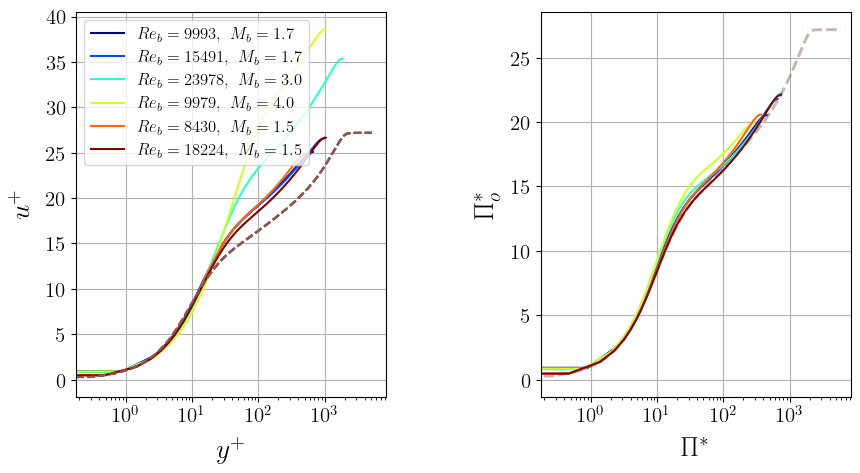

In [12]:
import matplotlib.pyplot as plt
Re_b_values = [9993, 15491, 23978, 9979, 8430, 18224]
M_b_values = [1.70, 1.70, 3.00, 4.00, 1.50, 1.50]

unique_indices = np.unique(index_data)
colors = plt.cm.jet(np.linspace(0, 1, len(unique_indices)))
plt.figure(figsize=(10, 5))
plt.rcParams['font.family'] = 'Times New Roman'  # Set the font to Times New Roman
plt.rcParams['text.usetex'] = True  # Use LaTeX for all text rendering
plt.subplot(1, 2, 2)  # (1 row, 2 columns, 1st subplot)
for i, idx in enumerate(unique_indices):
    mask = index_data == idx  # Find the points that correspond to the current index
    plt.semilogx(y_plus,U_utau ,'--',linewidth=2,alpha=0.1)
    plt.semilogx(pi[mask,0], Y_n[mask], '-', label=f'$Re_b={Re_b_values[i]},~M_b={M_b_values[i]}$', color=colors[i])

#plt.xlabel(Pi_i_lab[0], fontsize=25, labelpad=8)
#plt.ylabel(Pi_o_lab[0], fontsize=20, labelpad=8)
plt.xlabel(r'$\Pi^*$', fontsize=20, labelpad=8)
plt.ylabel(r'$\Pi_o^*$', fontsize=20, labelpad=8)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True)
#plt.legend(fontsize=8)

# Second subplot: plot(X[:, 0], Y) with same color for the same index
plt.subplot(1, 2, 1)  # (1 row, 2 columns, 2nd subplot)
for i, idx in enumerate(unique_indices):
    mask = index_data == idx  # Find the points that correspond to the current index
    plt.semilogx(X[mask, 0] * X[mask, 5] / (X[mask, 4] / X[mask, 3]), Y[mask], '-', label=f'$Re_b={Re_b_values[i]},~M_b={M_b_values[i]}$', color=colors[i])

    plt.semilogx(y_plus,U_utau ,'--')
plt.xlabel(r'$y^+$', fontsize=20, labelpad=8)
plt.ylabel(r'$u^+$', fontsize=20, labelpad=8)
#plt.ylabel(r'${u}/{u_\tau}$', fontsize=20, labelpad=8)
#plt.xlabel(r'$\frac{y \rho u_\tau}{\mu}$', fontsize=20, labelpad=8)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True)
plt.subplots_adjust(wspace=0.5)
plt.legend(fontsize=12,loc='upper left')


plt.savefig('Trans_ch_pipe.png', dpi=300, bbox_inches='tight')
plt.savefig('Trans_ch_pipe.eps', dpi=300, bbox_inches='tight')

# Show the plots
plt.show()

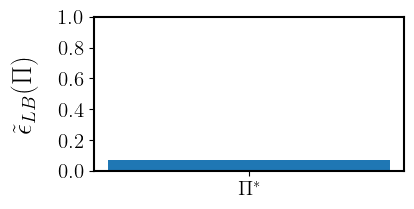

In [13]:
input_list = [calc_pi_omega(np.array(omega), X) for omega in normalized_coef_pi_list]
input_PI = np.column_stack(input_list)
# Initialize an empty list for exp(-MI) values
exp_mi_values = []
x_labels = []

# Step 1: Check the number of columns in input_PI
if input_PI.shape[1] == 1:
    # Only one column, calculate and plot only the total MI
    mi_total = MI_d_binning(input_PI, Y, 100)
    exp_mi_total = np.exp(-mi_total)
    exp_mi_values.append(exp_mi_total)
    x_labels.append(r"${\Pi^*}$")
else:
    # Multiple columns, calculate exp(-I) for each column and the total MI
    for j in range(input_PI.shape[1]):
        mi = KraskovMI1_nats(input_PI[:, j].reshape(-1, 1), Y, 5)
        exp_mi = np.exp(-mi)
        exp_mi_values.append(exp_mi)
        x_labels.append(f"$\\Pi_{j+1}^*$")
    
    # Calculate exp(-I) for the entire input_PI and Y
    mi_total = KraskovMI1_nats(input_PI, Y, 5)
    exp_mi_total = np.exp(-mi_total)
    exp_mi_values.append(exp_mi_total)
    x_labels.append(r"$\mathbf{\Pi^*}$")

# Plotting the results
plt.figure(figsize=(4, 2))
plt.rcParams['font.family'] = 'Times New Roman'  # Set the font to Times New Roman
plt.rcParams['text.usetex'] = True  # Use LaTeX for all text rendering
plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['right'].set_linewidth(1.5)
plt.bar(x_labels, exp_mi_values)
#plt.xlabel("Features", fontsize=20, labelpad=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel(r'$\tilde{\epsilon}_{ L B}(\Pi)$', fontsize=20, labelpad=15)
plt.ylim([0, 1])
plt.savefig('Velocity_trans_rank.eps', dpi=300, bbox_inches='tight')
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


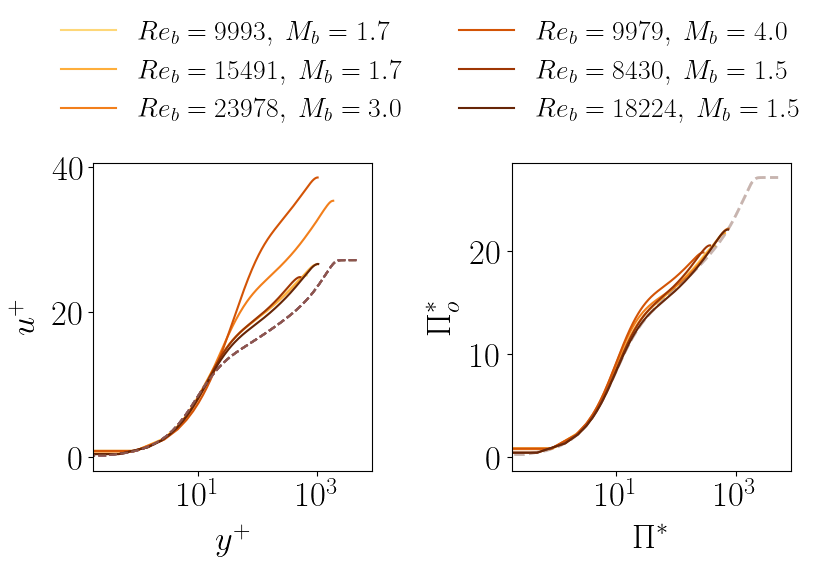

In [14]:
import matplotlib.pyplot as plt
cmap = plt.get_cmap('YlOrBr')
# Generate 5 colors evenly spaced in the colormap
colors = [cmap(i) for i in np.linspace(0.3, 1, 6)]# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(9, 4))  # 1 row, 2 columns

# First subplot
for i, idx in enumerate(unique_indices):
    mask = index_data == idx  # Find the points that correspond to the current index
    axes[0].semilogx(
        X[mask, 0] * X[mask, 5] / (X[mask, 4] / X[mask, 3]),
        Y[mask],
        '-',
        label=f'$Re_b={Re_b_values[i]},~M_b={M_b_values[i]}$',
        color=colors[i]
    )
    axes[0].semilogx(y_plus, U_utau, '--')
axes[0].set_xlabel(r'$y^+$', fontsize=25, labelpad=8)
axes[0].set_ylabel(r'$u^+$', fontsize=25, labelpad=8)
axes[0].tick_params(axis='both', labelsize=25)
# axes[0].grid(True)

# Second subplot
for i, idx in enumerate(unique_indices):
    mask = index_data == idx  # Find the points that correspond to the current index
    axes[1].semilogx(
        pi[mask, 0],
        Y_n[mask],
        '-',
        label=f'$Re_b={Re_b_values[i]},~M_b={M_b_values[i]}$',
        color=colors[i]
    )
    axes[1].semilogx(y_plus, U_utau, '--', linewidth=2, alpha=0.1)
axes[1].set_xlabel(r'$\Pi^*$', fontsize=25, labelpad=8)
axes[1].set_ylabel(r'$\Pi_o^*$', fontsize=25, labelpad=8)
axes[1].tick_params(axis='both', labelsize=25)
# axes[1].grid(True)

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.5)
# Collect handles and labels from both subplots
handles, labels = [], []
for ax in axes:
    h, l = ax.get_legend_handles_labels()
    handles += h
    labels += l

# Remove duplicate legend entries
unique = dict(zip(labels, handles))  # Use dictionary to ensure uniqueness
handles, labels = unique.values(), unique.keys()

# Create a shared legend
fig.legend(
    handles,
    labels,
    loc='upper center',
    fontsize=20,
    ncol=2,  # Adjust the number of columns
    bbox_to_anchor=(0.5, 1.3),  # Position above the plots
    frameon=False
)

# Save and show the plots
plt.savefig('Trans_ch_pipe.png', dpi=300, bbox_inches='tight')
plt.savefig('Trans_ch_pipe.eps', dpi=300, bbox_inches='tight',transparent = 'True')
plt.show()


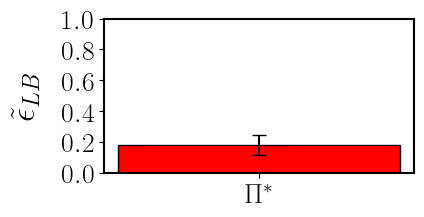

In [15]:
# Function to calculate exp(-MI) bound and its uncertainty (UQ)
def calculate_bound_and_uq(input_data, output_data, num_trials):
    # Compute MI using all the data
    mi_full = KraskovMI1_nats(input_data, output_data, 5)
    exp_mi_full = np.exp(-mi_full)

    exp_mi_half_values = []
    for _ in range(num_trials):
        # Randomly select half of the data
        indices = np.random.choice(input_data.shape[0], size=input_data.shape[0] // 2, replace=False)
        input_half = input_data[indices]
        output_half = output_data[indices]
        # Compute MI for this subset and calculate exp(-MI_half)
        mi_half = KraskovMI1_nats(input_half, output_half, 5)
        exp_mi_half_values.append(np.exp(-mi_half))

    # Calculate the mean of exp(-MI_half)
    exp_mi_half_mean = np.mean(exp_mi_half_values)
    
    # UQ is the absolute difference between exp(-MI_full) and exp_mi_half_mean
    uq = abs(exp_mi_full - exp_mi_half_mean)
    
    return exp_mi_full, uq

# Prepare input data
input_list = [calc_pi_omega(np.array(omega), X) for omega in normalized_coef_pi_list]
input_PI = np.column_stack(input_list)

# Initialize lists for results
exp_mi_values = []
uq_values = []
x_labels = []

# Number of trials for calculating exp(-MI_half)
num_trials = 10  # Adjust for accuracy vs computation time

# Check the number of columns in input_PI
if input_PI.shape[1] == 1:
    # Only one column, calculate and plot only the total MI
    exp_mi_full, uq = calculate_bound_and_uq(input_PI, Y, num_trials)
    exp_mi_values.append(exp_mi_full)
    uq_values.append(uq)
    x_labels.append(r"$\mathbf{\Pi^*}$")
else:
    # Multiple columns, calculate exp(-I) for each column and the total MI
    for j in range(input_PI.shape[1]):
        exp_mi_full, uq = calculate_bound_and_uq(input_PI[:, j].reshape(-1, 1), Y, num_trials)
        exp_mi_values.append(exp_mi_full)
        uq_values.append(uq)
        x_labels.append(f"$\\Pi_{j+1}^*$")
    
    # Calculate exp(-I) for the entire input_PI and Y
    exp_mi_full, uq = calculate_bound_and_uq(input_PI, Y, num_trials)
    exp_mi_values.append(exp_mi_full)
    uq_values.append(uq)
    x_labels.append(r"$[\Pi_1^*,\Pi_2^*]$")

# Plotting the results
plt.figure(figsize=(4, 2))
x_labels[0] = r"$\Pi^{*}$"

plt.rcParams['font.family'] = 'Times New Roman'  # Set the font to Times New Roman
plt.rcParams['text.usetex'] = True  # Use LaTeX for all text rendering
plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['right'].set_linewidth(1.5)

# Use uq_values as the error bars
plt.bar(x_labels, exp_mi_values, yerr=uq_values, capsize=5, edgecolor='black',color = 'red')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel(r'$\tilde{\epsilon}_{L B}$', fontsize=25, labelpad=15)
plt.ylim([0, 1])
plt.savefig('Velocity_trans_rank.eps', dpi=300, bbox_inches='tight',transparent = 'True')
plt.show()